### Generate Sources

C:\Users\Grant\AppData\Local\Temp\ipykernel_26092\2985738100.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


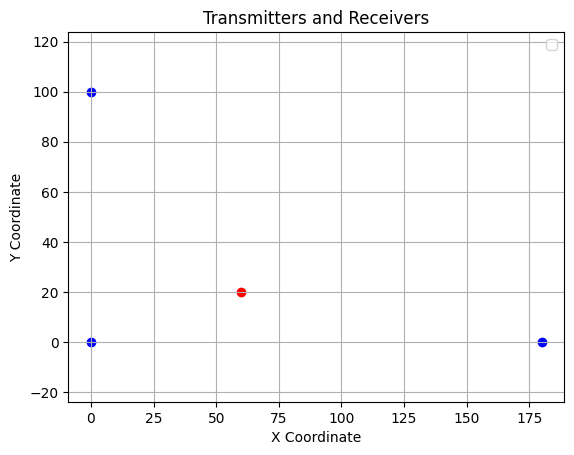

In [38]:
import matplotlib.pyplot as plt

# Define transmitters and receivers using tuples
transmitters = [[60,20]]

receivers = [[0, 0], [180, 0], [0, 100]]

# Plot transmitters
for transmitter in transmitters:
    plt.scatter(transmitter[0], transmitter[1], color='red', label='Transmitter' if transmitter == (10, 10) else "")

# Plot receivers
for receiver in receivers:
    plt.scatter(receiver[0], receiver[1], color='blue', label='Receiver' if receiver == (0, 0) else "")

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Transmitters and Receivers')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()


#### Simulate Emitted Signal

Text(0.5, 1.0, 'Spectrum of LFM Waveform')

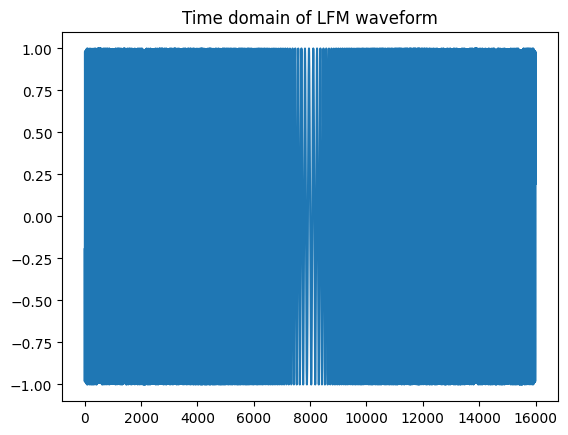

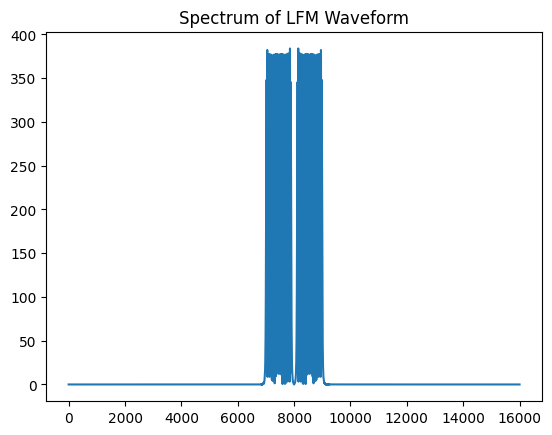

In [39]:
import numpy as np

# lfm_waveform = np.ones(16000)
# Parameters
sampling_rate = 16000  # Samples per second
transmission_duration = 1         # Total duration of the chirp in seconds
f_start = 100          # Start frequency in Hz
f_end = 1000           # End frequency in Hz

# Time array
t = np.linspace(0, transmission_duration, int(sampling_rate * transmission_duration))

# Time for the up and down segments
half_duration = transmission_duration / 2
t_up = t[:len(t)//2]  # First half for up chirp
t_down = t[len(t)//2:]  # Second half for down chirp
k = (f_end - f_start) / half_duration  # Chirp rate for up

up_chirp   = np.sin(2 * np.pi * (f_start * t_up + 0.5 * k * t_up**2))
down_chirp = np.flip(up_chirp)

# Combine the up and down chirps
lfm_waveform = np.concatenate((down_chirp,-up_chirp))
plt.plot(lfm_waveform)
plt.title("Time domain of LFM waveform")
plt.figure()
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lfm_waveform))))
plt.title("Spectrum of LFM Waveform")

#### Simulate Receival

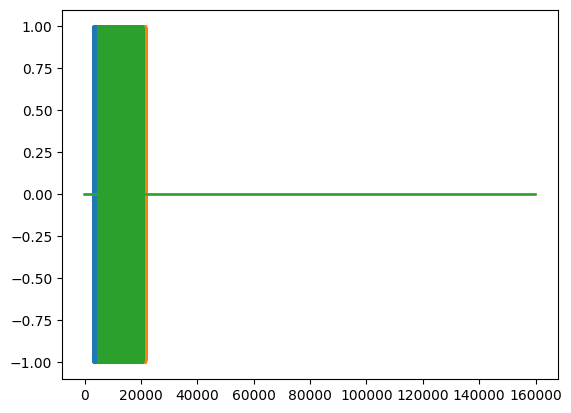

In [40]:
recording_duration_s = 10
propogation_velocity_mps = 330

recieved_signals = []

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Calculate distances between transmitters and receivers
distances = []
for transmitter in transmitters:

    distances_tmp = []

    for receiver in receivers:
        distance = euclidean_distance(transmitter, receiver)
        distances_tmp.append(distance)

    distances.append(distances_tmp)


# Figure out how many samples to prepend 
number_of_receivers = len(receivers)
number_of_transmitters = len(transmitters)

for rx_idx in range(number_of_receivers):
    
    rxer_signal = []

    for tx_idx in range(number_of_transmitters):

        samples_in_whole_signal = recording_duration_s*sampling_rate
        rxed_signal = np.zeros(samples_in_whole_signal)

        # Figure out how many delay samples are requried
        distances_from_tx_to_rx_s = distances[tx_idx][rx_idx]
        delay_from_tx_to_rx_s = distances_from_tx_to_rx_s/propogation_velocity_mps
        required_prepended_samples = int(np.ceil(delay_from_tx_to_rx_s*sampling_rate))

        # Add delays, the transmitted sig and then fill
        rxed_signal[:required_prepended_samples] = 0
        rxed_signal[required_prepended_samples:required_prepended_samples+len(lfm_waveform)] = lfm_waveform
        rxed_signal[required_prepended_samples+len(lfm_waveform):] = 0
        
        rxer_signal.append(rxed_signal)
        
    rxer_signal = np.sum(rxer_signal,axis=0)
    plt.plot(rxer_signal)

    recieved_signals.append(rxer_signal)


#### Add Some Noise For Fun

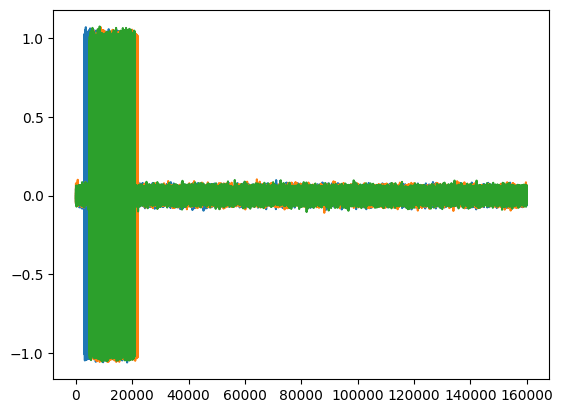

In [41]:
import numpy as np

# Assuming 'signal' is your input signal with shape (3, 160000)
receiver_count = np.shape(recieved_signals)[0]
sample_count = np.shape(recieved_signals)[1]
signal = np.random.rand(receiver_count, sample_count)  # Example signal

snr_db = 20  # Desired Signal-to-Noise Ratio in dB

for rxer_ix in range(receiver_count):

    signal_power = np.mean(recieved_signals[rxer_ix]**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate AWGN
    noise = np.random.normal(0, np.sqrt(noise_power), recieved_signals[rxer_ix].shape)
    # Add AWGN to the signal
    recieved_signals[rxer_ix] = recieved_signals[rxer_ix] + noise\
    
    plt.plot( recieved_signals[rxer_ix])

#### Simulate Signal Detection and Get Delays


In [49]:
# Just assume hi snr with single signal for now

max_indicies = []
num_signals = np.shape(recieved_signals)[0]

for i in range(num_signals):

    max_indicies_tmp = []

    for j in range(i+1, num_signals):  # Avoid repeating pairs and ignore autocorrelation
        
        A = np.fft.fft(recieved_signals[i]) 
        B = np.fft.fft(recieved_signals[j])
        correlation = np.fft.ifft(A*B)

        max_indicies_tmp.append(np.argmax(correlation))

    max_indicies.append(max_indicies_tmp)


differential_receiver_delays = []
for i in range(len(max_indicies)):

    differential_receiver_delays_tmp_s = []
    
    for j in range(len(max_indicies[i])):

        differential_delay_s = max_indicies[i][j]/sampling_rate
        differential_receiver_delays_tmp_s.append(differential_delay_s)
        print("delay " + str(i) + str(i+(j+i)) + "  - samples -   " + str(max_indicies[i][j]))
    
    differential_receiver_delays.append(differential_receiver_delays_tmp_s)


print()

for i in range(len(max_indicies)):
    for j in range(len(max_indicies[i])):
        print("delay " + str(i) + str(i+(j+i)) + "  - delays in seconds -   " + str(differential_receiver_delays[i][j]))

delay 00  - samples -   24976
delay 01  - samples -   23926
delay 12  - samples -   26758

delay 00  - delays -   1.561
delay 01  - delays -   1.495375
delay 12  - delays -   1.672375


#### Fiugre Out Delays